In [1]:
import numpy as np
import pandas as pd
import mlflow
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [2]:
mlflow.set_experiment(experiment_id="0")

mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:5000")

2025/03/19 10:29:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2025/03/19 10:29:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
# List files available
print(os.listdir("input/"))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [4]:
# Training data
app_train = pd.read_csv('input/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Testing data features
app_test = pd.read_csv('input/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

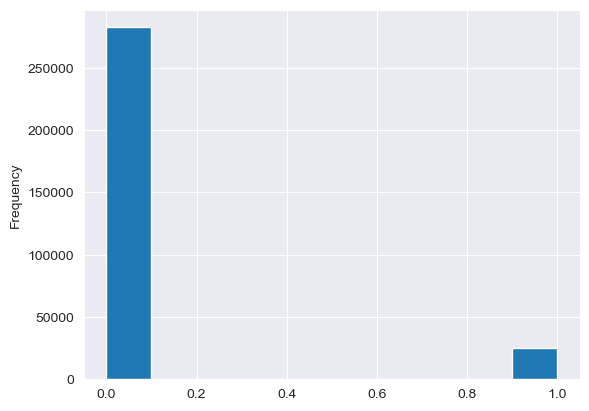

In [7]:
app_train['TARGET'].astype(int).plot.hist();

In [8]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                               "There are " + str(mis_val_table_ren_columns.shape[0]) +
           " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [9]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [10]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [11]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [12]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [13]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [14]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [15]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [16]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

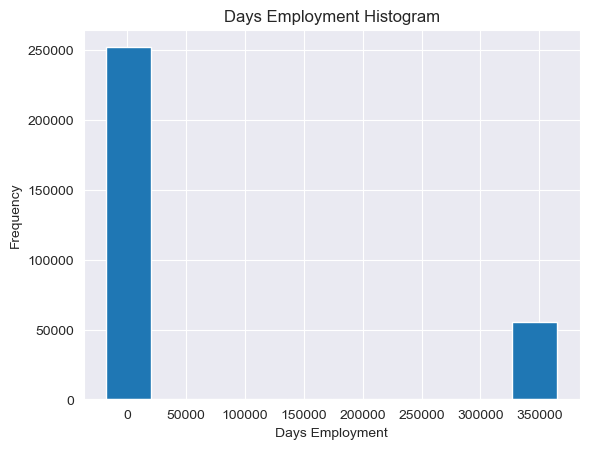

In [17]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [18]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


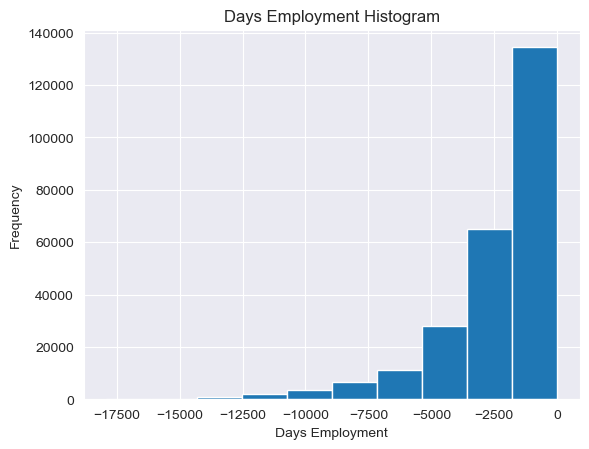

In [19]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [20]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [21]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

In [22]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

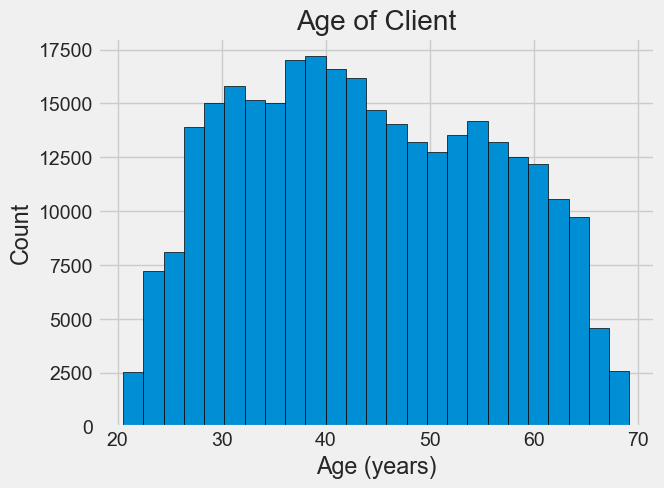

In [23]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

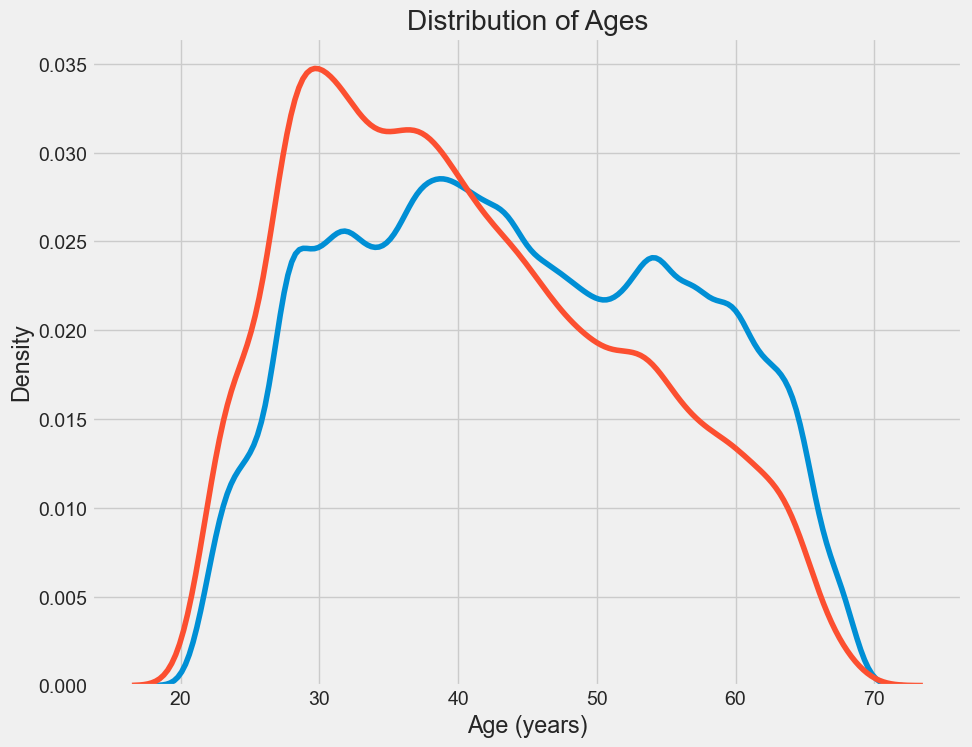

In [24]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [25]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [26]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


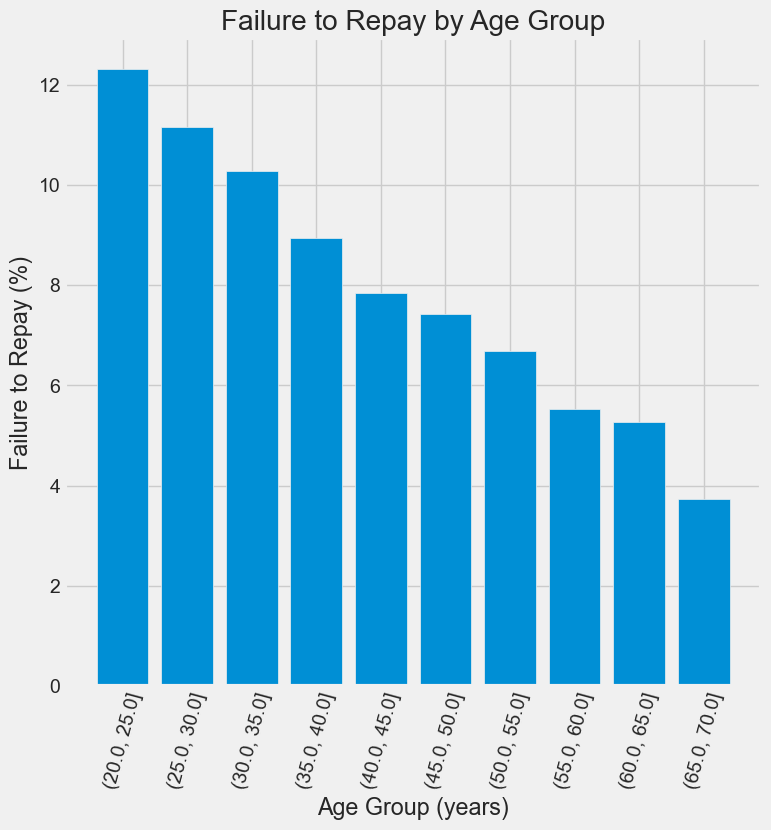

In [27]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

In [28]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


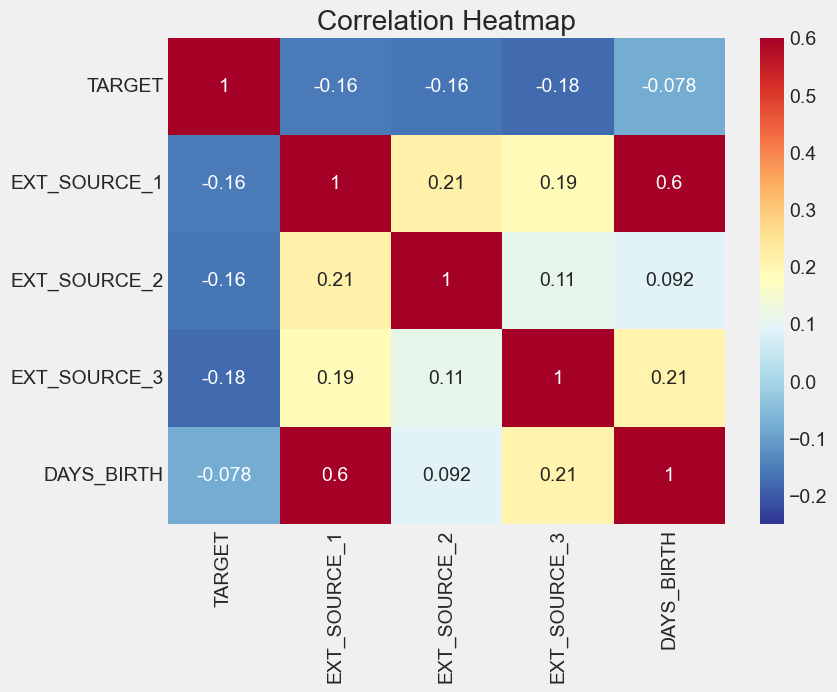

In [29]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

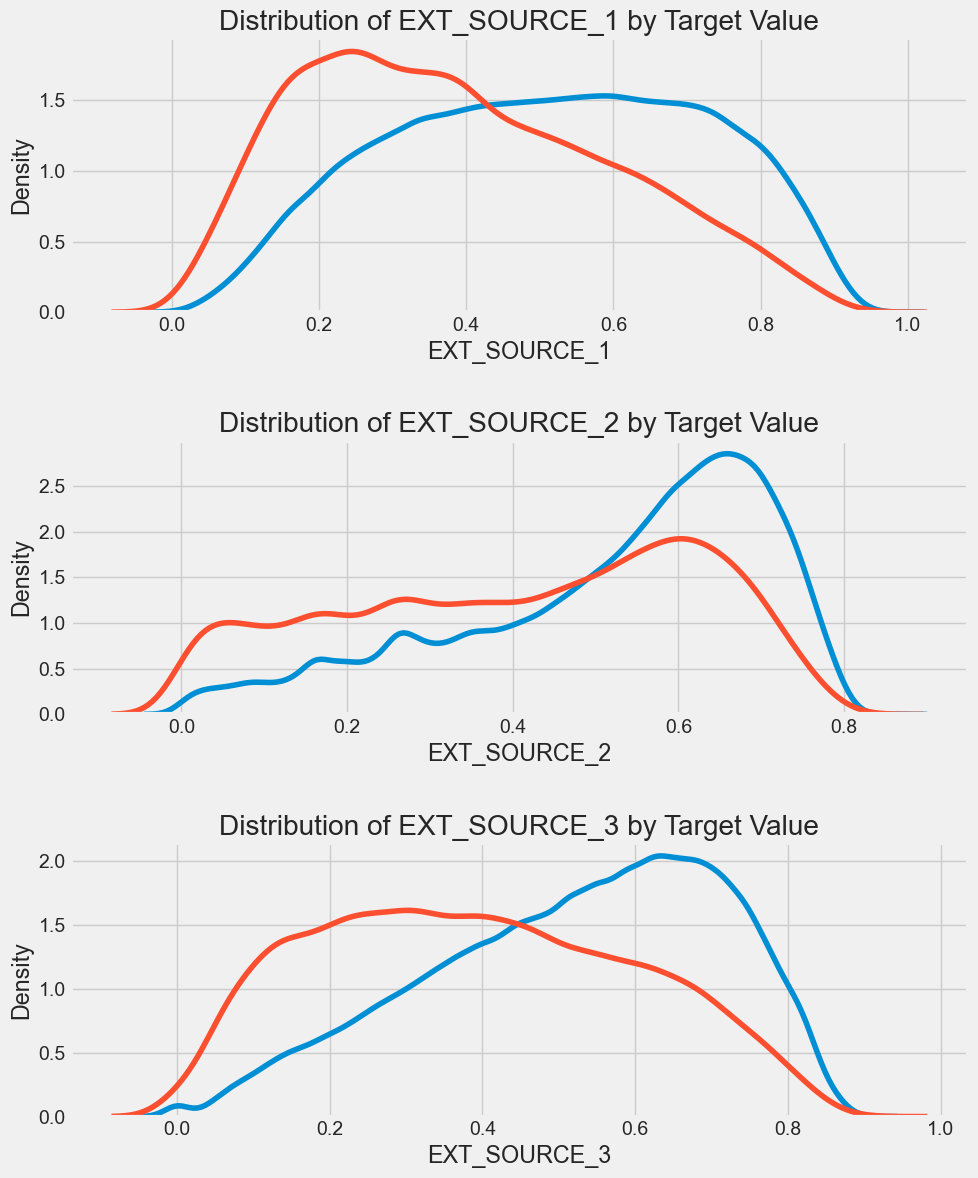

In [30]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

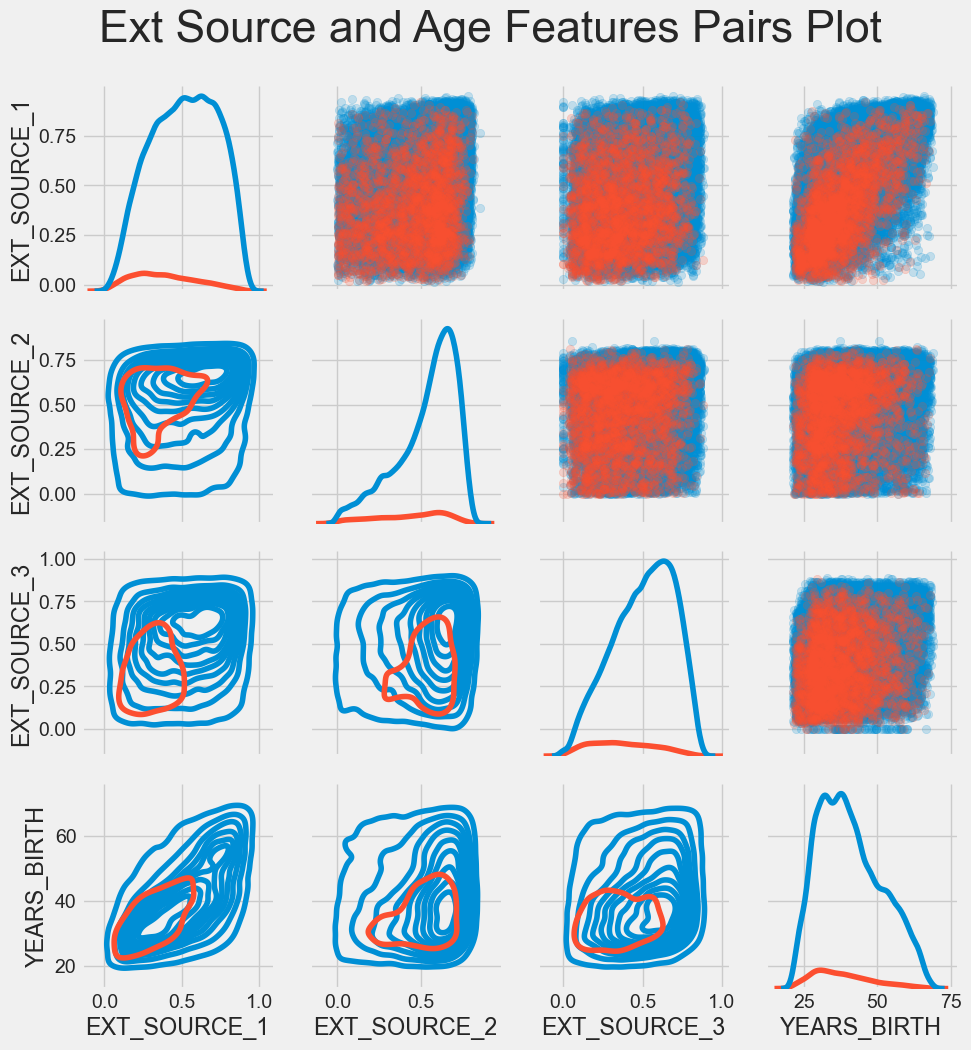

In [31]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET',
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In [32]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [33]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

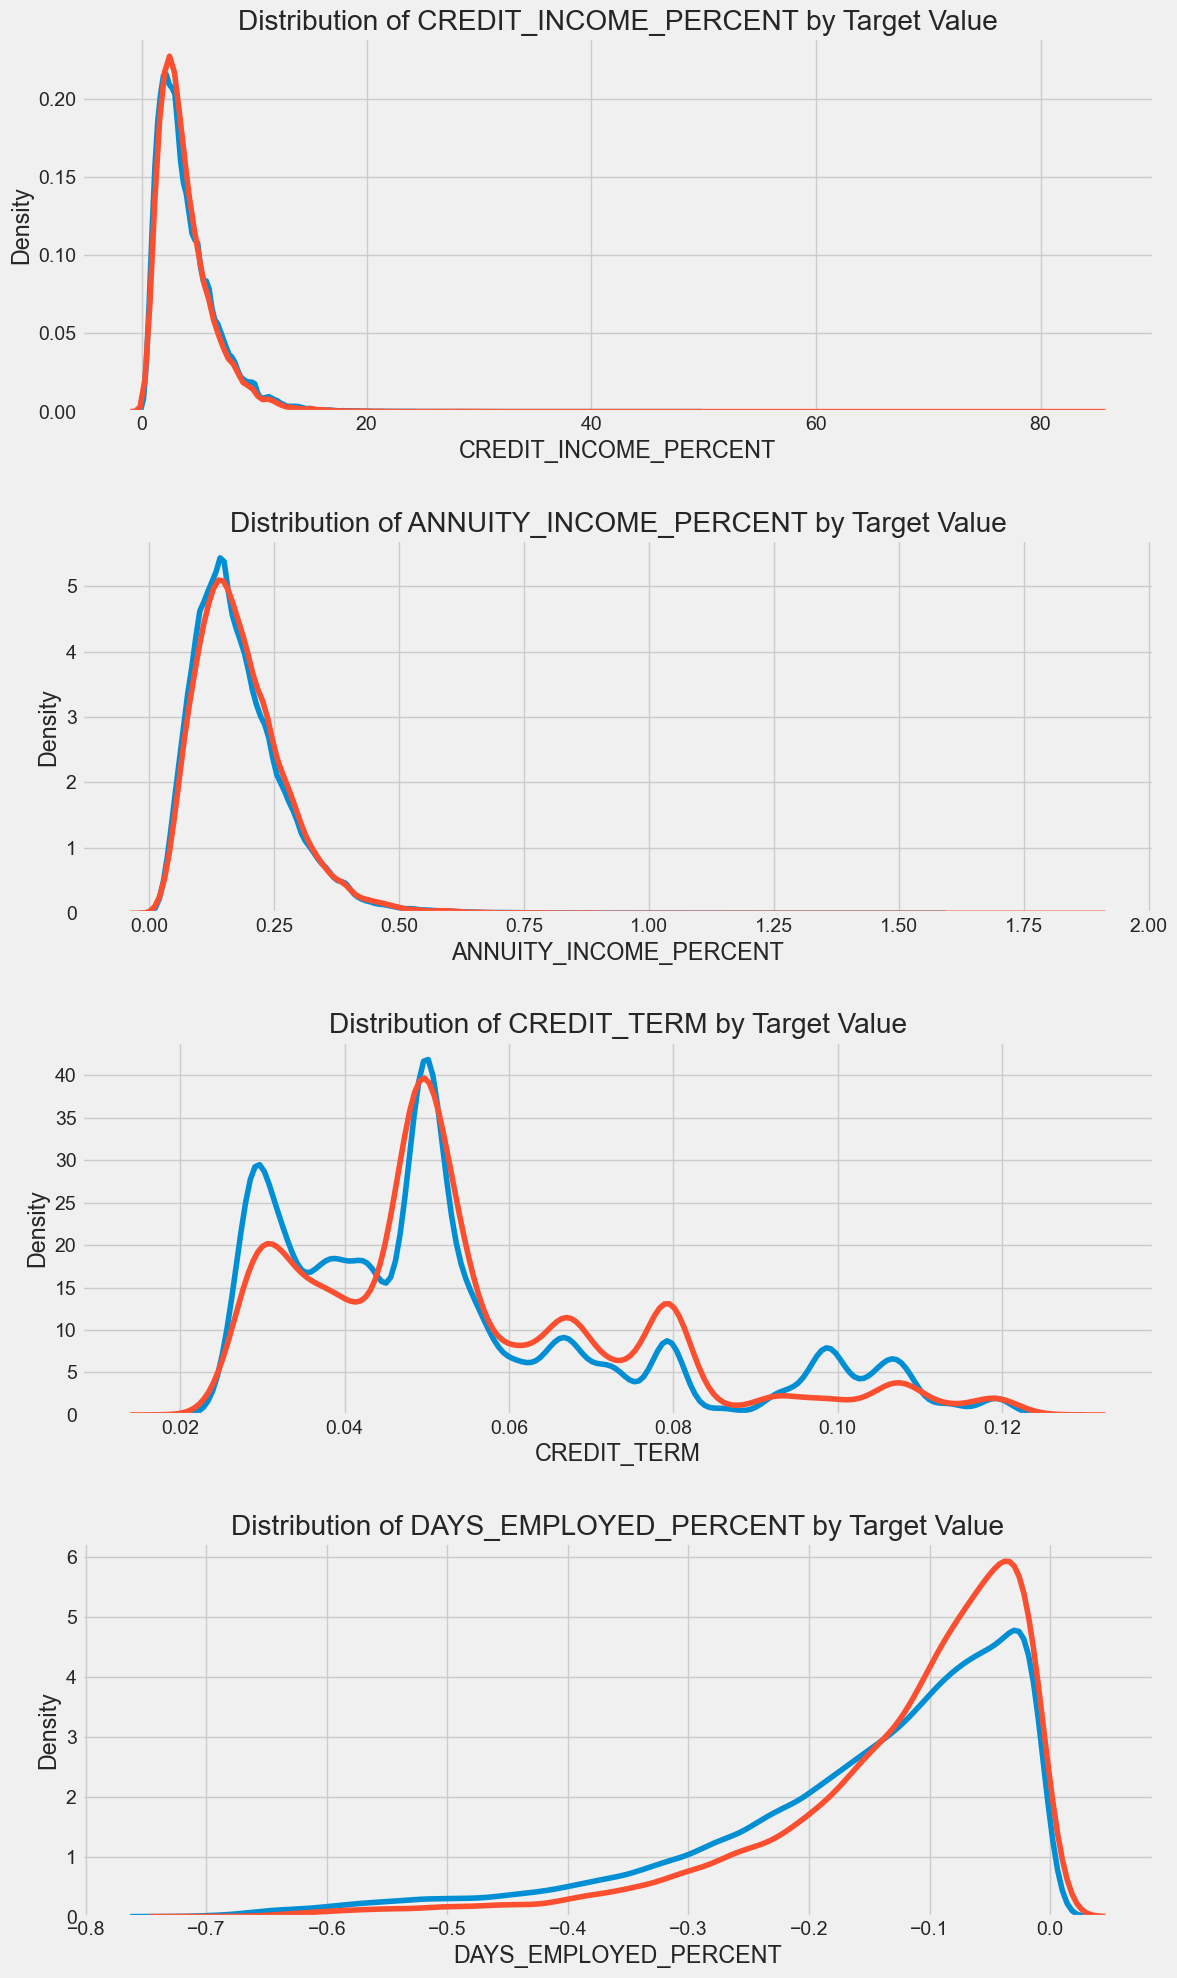

In [34]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_auc_score

# Optimisation des types de données
def optimize_dataframe(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = df[col].astype('float32')
    return df

app_train = optimize_dataframe(app_train)
app_test = optimize_dataframe(app_test)

id_test = app_test['SK_ID_CURR']

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

feature_names = train.columns

imputer = SimpleImputer(strategy = 'median')
imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(app_test)

X_train, X_val, y_train, y_val = train_test_split(train, train_labels, test_size=0.2, random_state=42, stratify=train_labels)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(test)

# Gestion du déséquilibre avec SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Distribution après SMOTE:")
print(y_train_res.value_counts())

2025/03/19 10:35:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: API request to http://localhost:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002B310E1C5C0>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))


Distribution après SMOTE:
TARGET
0    226148
1    226148
Name: count, dtype: int64


In [36]:
from sklearn.metrics import fbeta_score

# Définition des modèles et des grilles de recherche
models_params = {
    'Logistic Regression': (LogisticRegression(class_weight='balanced', random_state=42),
                            {'C': [0.1, 1, 10]}),
    'Random Forest': (RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=4),
                      {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, 20]}),
    'LightGBM': (LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=4),
                 {'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2]})
}

results = {}
feature_importances = {}
predictions = {}

# Pondération des FP et FN
alpha = 10  # Poids des faux positifs
beta = 1   # Poids des faux négatifs

for name, (model, params) in models_params.items():
    try:
        grid_search = RandomizedSearchCV(model, params, cv=3, scoring='roc_auc', n_jobs=4, n_iter=5, random_state=42, refit=True)
        grid_search.fit(X_train_res, y_train_res)

        if hasattr(grid_search, 'best_estimator_'):
            best_model = grid_search.best_estimator_
        else:
            print(f"Aucun modèle valide trouvé pour {name}, utilisation du modèle par défaut.")
            best_model = model.fit(X_train_res, y_train_res)

        y_pred = best_model.predict(X_val)
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]

        # Matrice de confusion
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

        # Score pondéré
        weighted_score = alpha * fp + beta * fn

        results[name] = {
            'Best Params': grid_search.best_params_ if hasattr(grid_search, 'best_params_') else 'N/A',
            'AUC-ROC': roc_auc_score(y_val, y_pred_proba),
            'F1-Score': classification_report(y_val, y_pred, output_dict=True)['weighted avg']['f1-score'],
            'Recall': classification_report(y_val, y_pred, output_dict=True)['weighted avg']['recall'],
            'F-beta Score (β=2)': fbeta_score(y_val, y_pred, beta=0.2, average='weighted'),
            'Weighted Score': weighted_score
        }

        # Extraction des importances des features
        if hasattr(best_model, 'feature_importances_'):
            feature_importances[name] = best_model.feature_importances_

        # Prédictions finales sur le test
        predictions[name] = best_model.predict_proba(X_test)[:, 1]

    except Exception as e:
        print(f"Erreur pour {name} : {e}")

# Affichage des résultats
results_df = pd.DataFrame(results).T
print(results_df)

2025/03/19 10:40:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: API request to http://localhost:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002B3110FF680>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))
2025/03/19 10:47:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: API request to http://localhost:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002B3110CFF80>: Failed to establish a new connection: [Wi

[LightGBM] [Info] Number of positive: 226148, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.097247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40002
[LightGBM] [Info] Number of data points in the train set: 452296, number of used features: 235
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2025/03/19 10:53:15 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: API request to http://localhost:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002B310E1C170>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))


                                                      Best Params   AUC-ROC  \
Logistic Regression                                     {'C': 10}  0.741939   
Random Forest              {'n_estimators': 100, 'max_depth': 20}   0.69516   
LightGBM             {'n_estimators': 100, 'learning_rate': 0.05}  0.727258   

                     F1-Score    Recall F-beta Score (β=2) Weighted Score  
Logistic Regression  0.766397  0.698763           0.882271         169727  
Random Forest        0.882679  0.906574           0.867902          15907  
LightGBM             0.881226  0.919126           0.855275           5253  


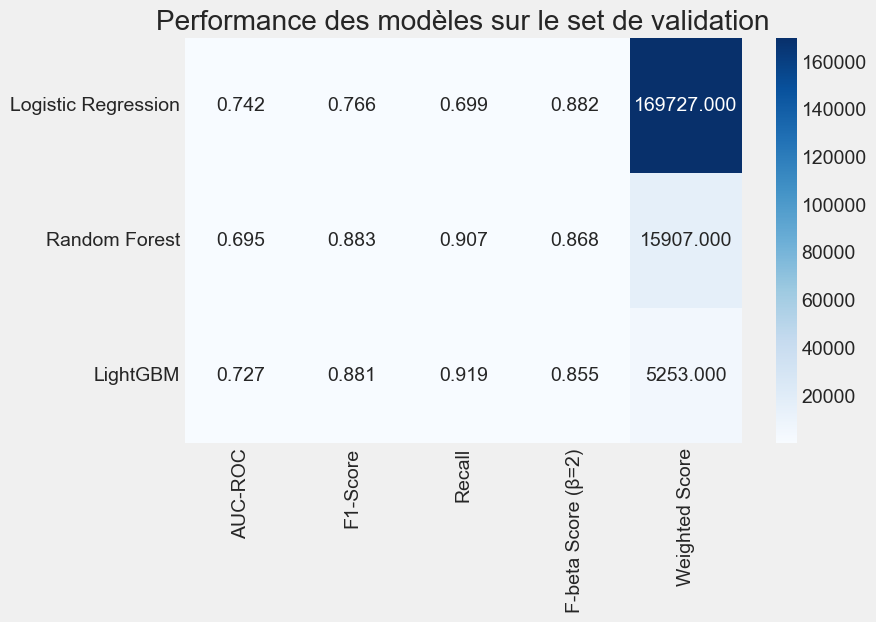

In [37]:
# Visualisation des scores
plt.figure(figsize=(8, 5))

for col in results_df.drop(columns=['Best Params']).select_dtypes(include=['object']).columns:
    results_df[col] = results_df[col].astype('float32')

sns.heatmap(results_df.drop(columns=['Best Params']), annot=True, cmap='Blues', fmt='.3f')
plt.title('Performance des modèles sur le set de validation')
plt.show()

In [38]:
# Sauvegarde des prédictions finales
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('predictions.csv', index=False)
print("Les prédictions ont été sauvegardées dans 'predictions.csv'")

Les prédictions ont été sauvegardées dans 'predictions.csv'


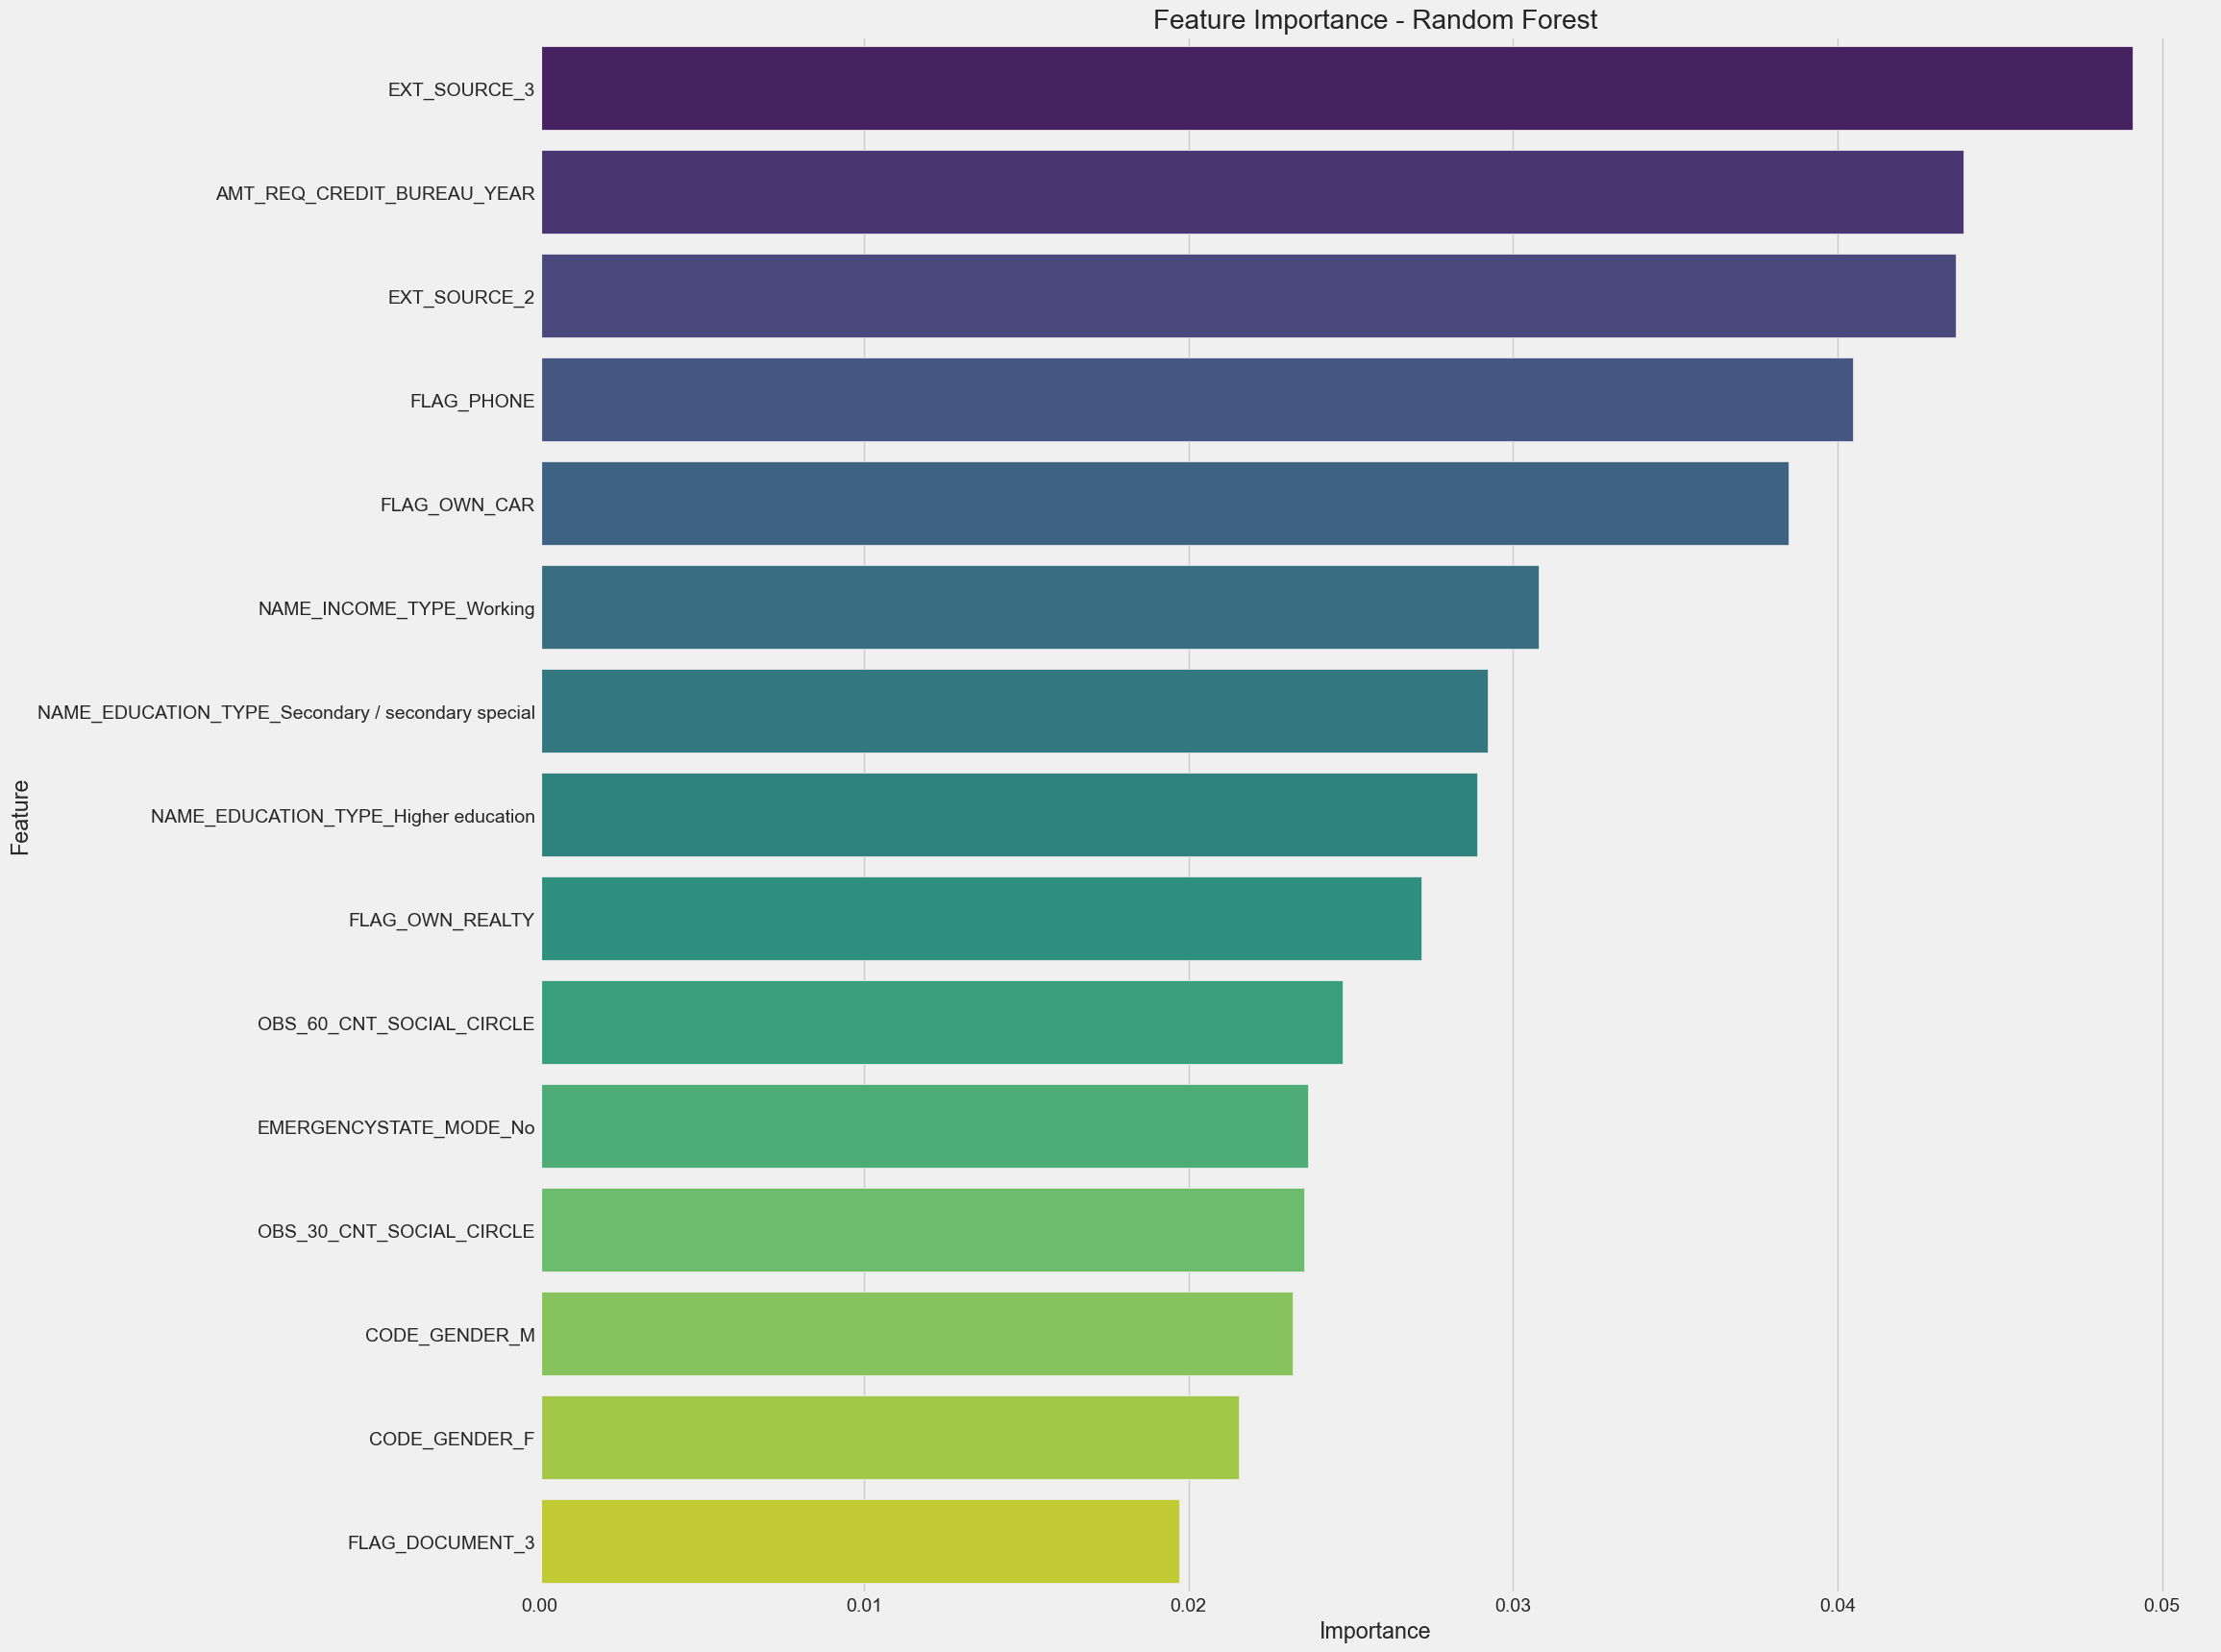

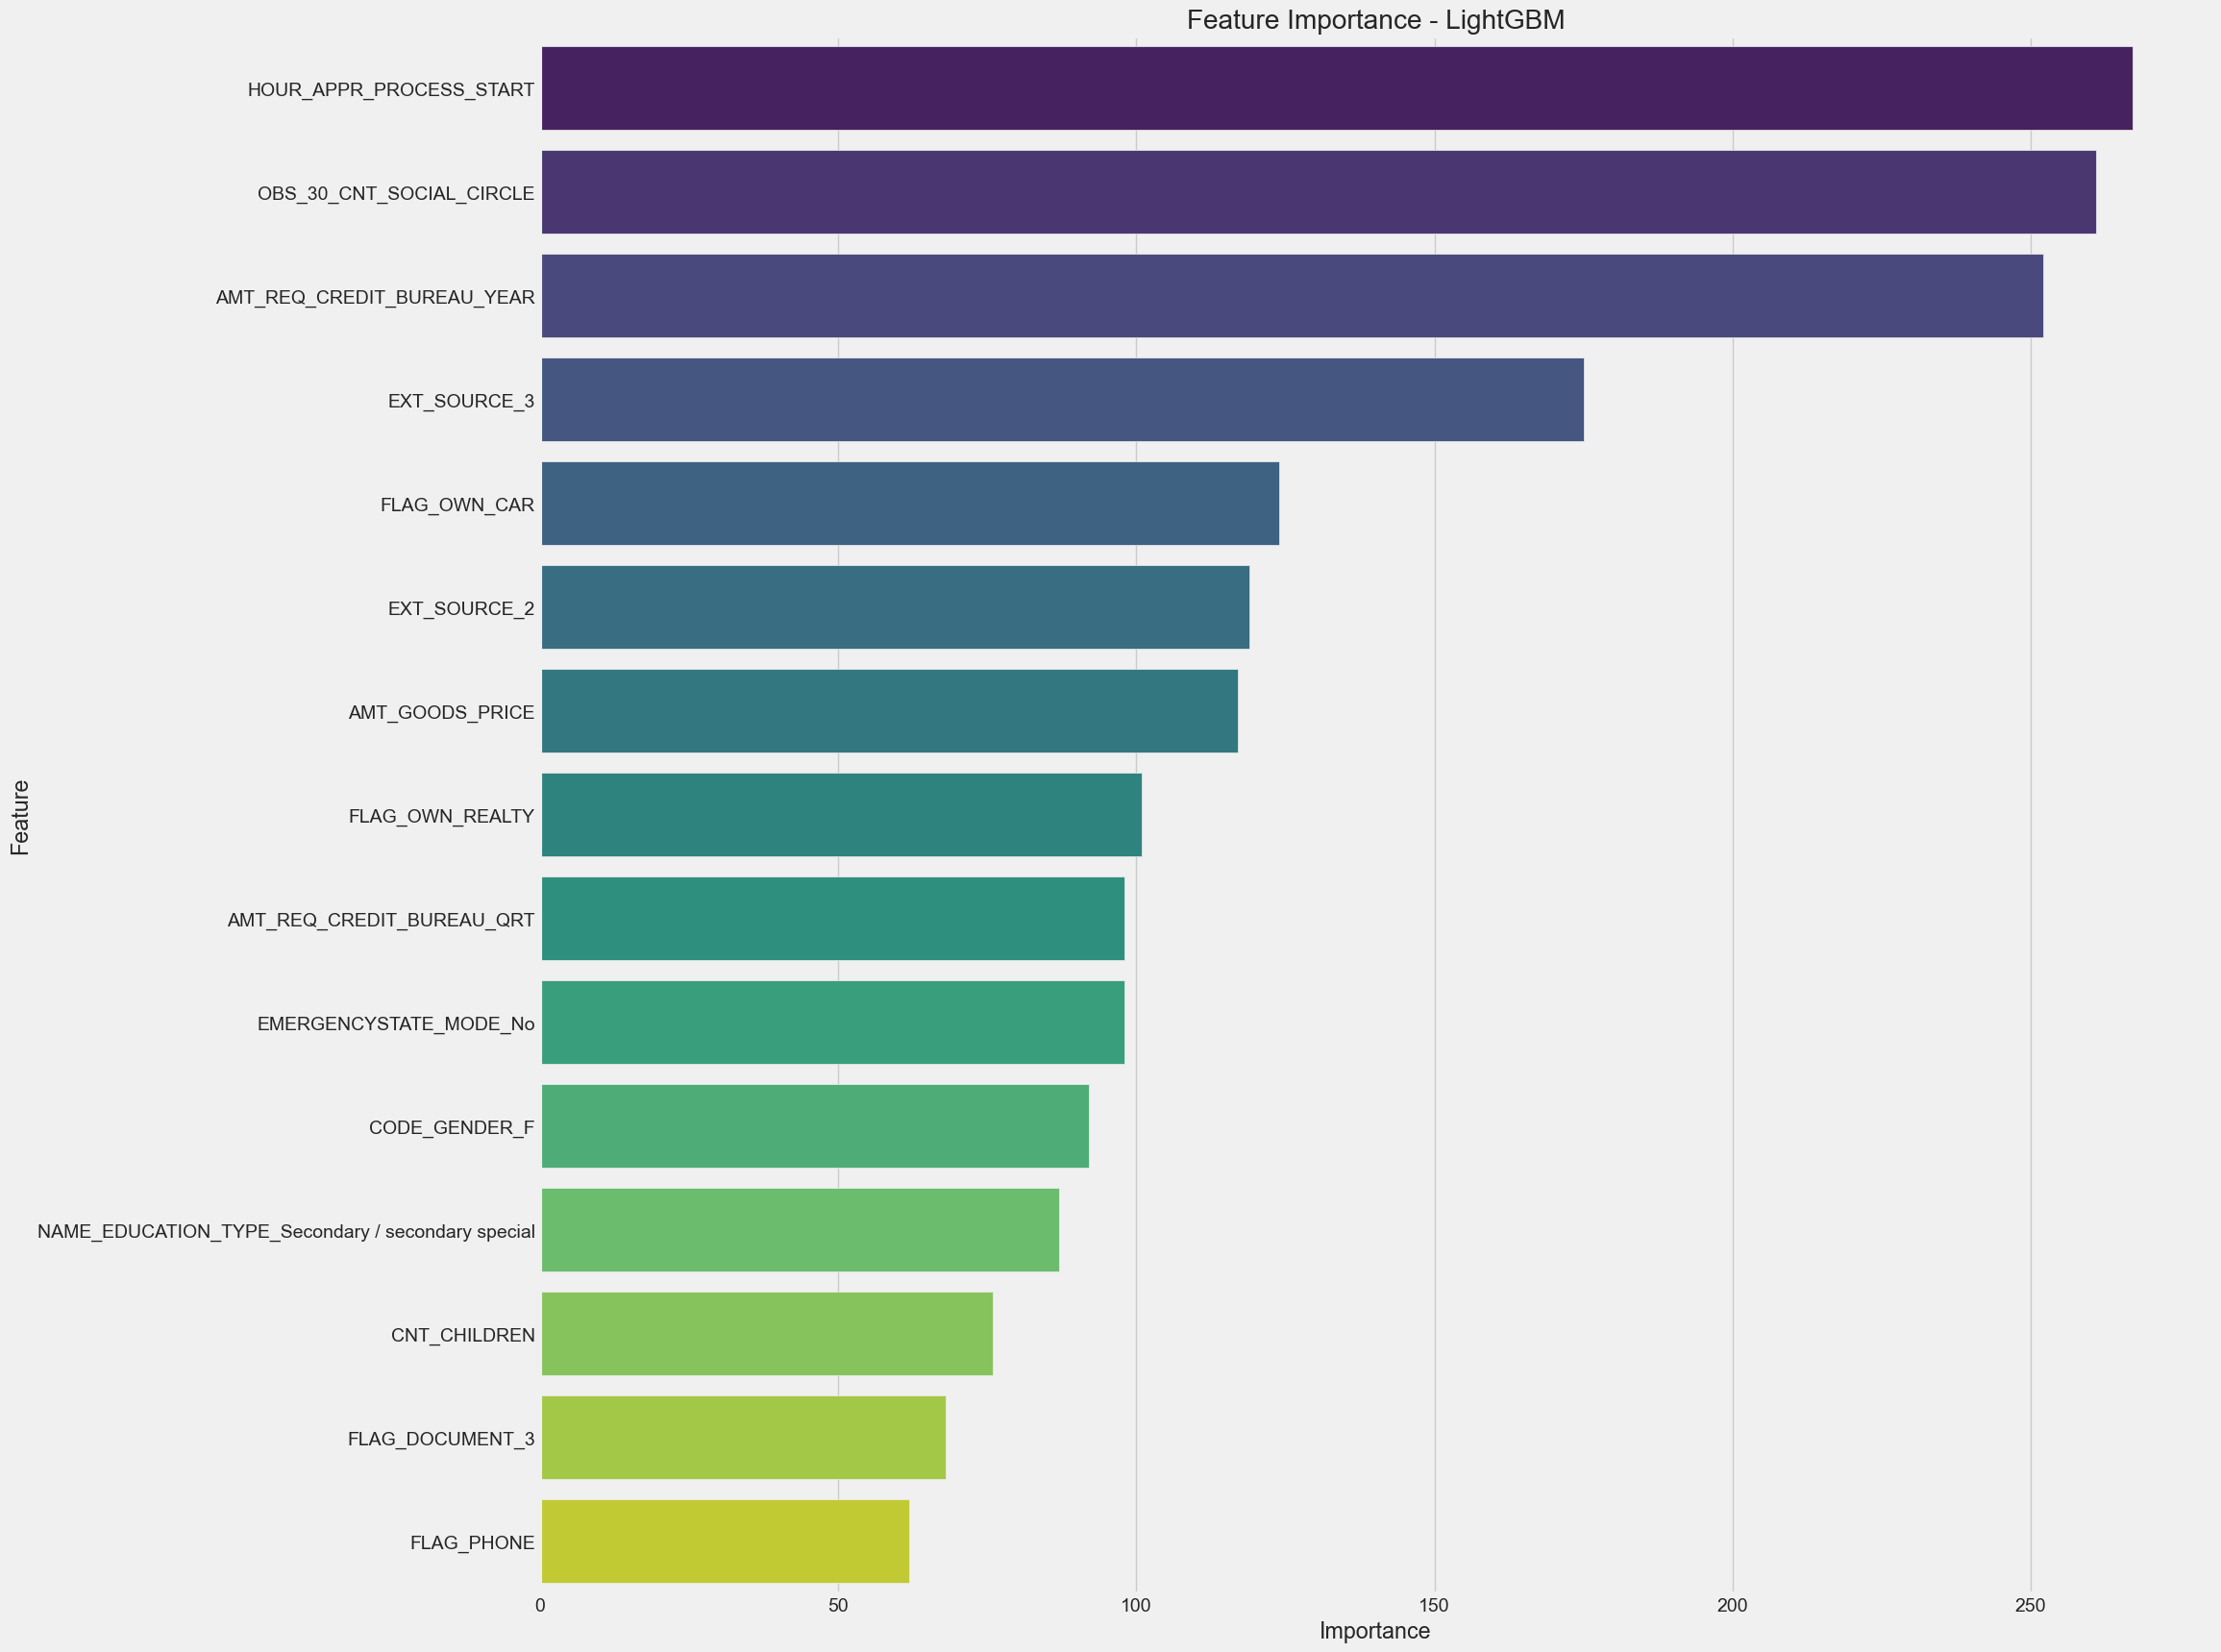

In [39]:
# Visualisation des importances des features
for name, importance in feature_importances.items():
    plt.figure(figsize=(20, 20))
    importance_df = pd.DataFrame({'Feature': feature_names[:len(importance)], 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Feature Importance - {name}')
    plt.show()

In [40]:
import psutil
print(f"Utilisation de la RAM avant entraînement: {psutil.virtual_memory().available / (1024**3):.2f} GB disponibles")


Utilisation de la RAM avant entraînement: 12.85 GB disponibles


In [41]:
import gc
gc.collect()

7273

In [42]:
# Trier les modèles d'abord par Weighted Score (ascendant), puis par AUC-ROC (descendant)
best_model_name = sorted(results.keys(), key=lambda x: (results[x]['Weighted Score'], -results[x]['AUC-ROC']))[0]
best_model = models_params[best_model_name][0]

if not hasattr(best_model, "booster_"):
    print("⏳ Entraînement du meilleur modèle...")
    best_model.fit(X_train, y_train)
    print("✅ Entraînement terminé.")

# Sauvegarde du modèle
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(test, 'df_test.pkl')

print(f"✅ Modèle sélectionné : {best_model_name} (sauvegardé sous 'best_model.pkl')")

⏳ Entraînement du meilleur modèle...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11679
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


2025/03/19 10:57:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during lightgbm autologging: API request to http://localhost:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000002B310D5D040>: Failed to establish a new connection: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée'))


✅ Entraînement terminé.
✅ Modèle sélectionné : LightGBM (sauvegardé sous 'best_model.pkl')
